## Исследование объявлений о продаже квартир

### Шаг 1. Изучение общей информации о данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np  
pd.set_option('display.max_columns', 35) 
df = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
col_names = df.columns.tolist()
col_names[16] = 'city_centers_nearest'
df.set_axis(col_names, axis = 'columns', inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
city_centers_nearest    18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

### Вывод

Файл содержит более 23 тысяч строк. Разделитель нестандартный.
22 колонки, изменила название одной колонки на city_centers_nearest для единообразия в названиях.
Увеличила количество колонок, который выводятся. 

### Шаг 2. Предобработка данных

In [2]:
df['ceiling_height'] = df['ceiling_height'].fillna(df['ceiling_height'].median())
df['floors_total'] = df['ceiling_height'].fillna(df['ceiling_height'].median())
df['is_apartment'] = df['is_apartment'].fillna(False)
df['balcony'] = df['balcony'].fillna(0)

df['parks_around3000'] = df['parks_around3000'].fillna(0)
df['ponds_around3000'] = df['ponds_around3000'].fillna(0)
df['days_exposition'] = df['days_exposition'].fillna(df['days_exposition'].median())

df.dropna(subset = ['locality_name'], inplace = True)

df['floors_total'] = df['floors_total'].astype('int')
df['balcony'] = df['balcony'].astype('int')
df['parks_around3000'] = df['parks_around3000'].astype('int')
df['ponds_around3000'] = df['ponds_around3000'].astype('int')
df['days_exposition'] = df['days_exposition'].astype('int')
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23650 non-null int64
last_price              23650 non-null float64
total_area              23650 non-null float64
first_day_exposition    23650 non-null datetime64[ns]
rooms                   23650 non-null int64
ceiling_height          23650 non-null float64
floors_total            23650 non-null int64
living_area             21752 non-null float64
floor                   23650 non-null int64
is_apartment            23650 non-null bool
studio                  23650 non-null bool
open_plan               23650 non-null bool
kitchen_area            21381 non-null float64
balcony                 23650 non-null int64
locality_name           23650 non-null object
airports_nearest        18116 non-null float64
city_centers_nearest    18139 non-null float64
parks_around3000        23650 non-null int64
parks_nearest           8064 non-null float64
ponds_around30

- Высоту потолков, количество комнат и количество дней продажи заполнила медианой
- Аппартаменты это особая категория если значение не указано, скорее всего это жилая квартира
- В колонках с парками и водоёмами поблизости пропуски заменила нулями, скорее всего их нет
- В столбце с балконами также пропуски заменила нулями
- Удалила строки в которых пропущено название населённого пункта, думаю здесь случайно могли попасть объявления из другого региона

#### Типы данных заменила так:
float на int заменила в столбцах, где не нужны дробные числа: этажи в доме, количество балконов, парков, водоёмов рядом, а также дней продажи.

Столбец first_day_exposition преобразовала в дату

### Шаг 3. Посчитайте и добавьте в таблицу

In [3]:
def floor(str):
    if str['floor'] == 1:
        return 'первый'
    elif str['floor'] == str['floors_total']:
        return 'последний'
    else:
        return 'другой'
    
    
def price(str):
    return int(str['last_price'] / str['total_area'])


def living_total_area(str):
        return str['living_area'] / str['total_area']

    
def kitchen_total_area(str):
        return str['kitchen_area'] / str['total_area']

   
df['floor_type'] = df.apply(floor, axis = 1)
df['price_area'] = df.apply(price, axis = 1)
df['year_exposition'] = df['first_day_exposition'].dt.year
df['month_exposition'] = df['first_day_exposition'].dt.month
df['day_exposition'] = df['first_day_exposition'].dt.dayofweek
df['living_total_area'] = df.apply(living_total_area, axis = 1)
df['kitchen_total_area'] = df.apply(kitchen_total_area, axis = 1)

df['rooms'] = df['rooms'].replace(0, 1)

rooms_area = df.pivot_table(index='rooms', values='living_total_area', aggfunc='median')
rooms_area.reset_index(inplace=True)

rooms_kitchen_area = df.pivot_table(index='rooms', values='kitchen_total_area', aggfunc='median')
rooms_kitchen_area.reset_index(inplace=True)

def living_area_agg(str):
    living_area = str['living_area']
    if(np.isnan(living_area)):
        return rooms_area[rooms_area['rooms'] == int(str['rooms'])].iloc[0,:]['living_total_area'] * float(str['total_area'])
    return living_area


def kitchen_area_agg(str):
    total_area = str['total_area']
    kitchen_area = str['kitchen_area']
    living_area = str['living_area']
    rooms = str['rooms']
    other_area = total_area - kitchen_area - living_area
    
    if(np.isnan(kitchen_area)):
        new_area = rooms_kitchen_area[rooms_area['rooms'] == int(rooms)].iloc[0,:]['kitchen_total_area'] * float(total_area)
        if (new_area + living_area > total_area):
            new_area = total_area - living_area / 2
        return new_area
    return kitchen_area


df['living_area'] = df.apply(living_area_agg, axis = 1)
df['kitchen_area'] = df.apply(kitchen_area_agg, axis = 1)


df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23698
Data columns (total 29 columns):
total_images            23650 non-null int64
last_price              23650 non-null float64
total_area              23650 non-null float64
first_day_exposition    23650 non-null datetime64[ns]
rooms                   23650 non-null int64
ceiling_height          23650 non-null float64
floors_total            23650 non-null int64
living_area             23650 non-null float64
floor                   23650 non-null int64
is_apartment            23650 non-null bool
studio                  23650 non-null bool
open_plan               23650 non-null bool
kitchen_area            23650 non-null float64
balcony                 23650 non-null int64
locality_name           23650 non-null object
airports_nearest        18116 non-null float64
city_centers_nearest    18139 non-null float64
parks_around3000        23650 non-null int64
parks_nearest           8064 non-null float64
ponds_around30

В столбцах с пропущенными значениями жилой площади и площади кухни оставила их пустыми. В этом случае соотношение жилой и общей площади, а также отношение площади кухни к общей тоже остались пустыми. 

Думаю, что эти площади не очень важны в данном случае.

<p>living_area вычислила из медианного отношения жилой площади к общей.</p>
<p>kitchen_area заполнила также, при этом если сумма площадей кухни и жилой площади больше общей, то взяла площадь кухни как половину разности общей и жилой плащади.Рассуждала так, что ещё есть корридор, балкон и т.д.</p>
</div>

### Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:

Общая плащадь


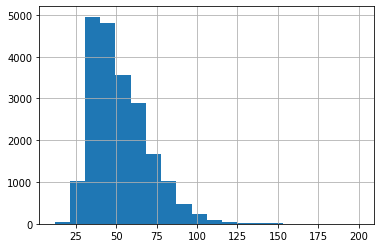

Цена


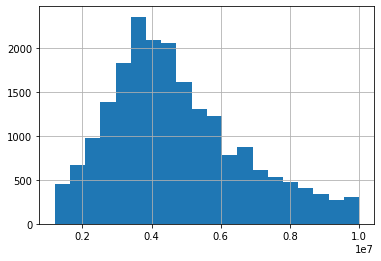

Количество комнат


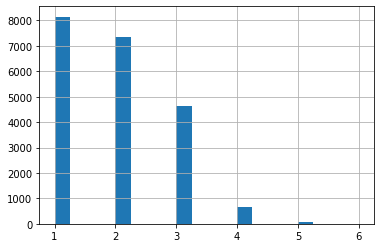

Высота потолка


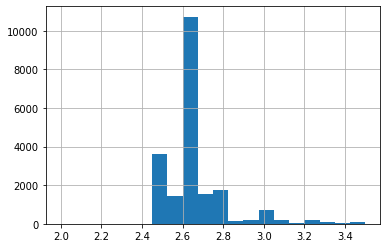

In [4]:
def edit_ceiling_height(value):
    if value >= 25:
        return value / 10
    return value


def plot_hist(df, col, title, diapason = []):
    print(title)
    if diapason:
        df[col].hist(bins=20, range=(diapason[0],diapason[1]))
    else:
        df[col].hist(bins=20)
    plt.show()
    
    
df = df.query('total_area <= 200 and last_price <= 10000000 and rooms <= 6')
df['ceiling_height'] = df['ceiling_height'].apply(edit_ceiling_height)
df = df.query('2.4 < ceiling_height <= 6')
df.sort_values(by='city_centers_nearest', ascending=False, inplace=True)


plot_hist(df, 'total_area', 'Общая плащадь', [12,200])
plot_hist(df, 'last_price', 'Цена', [1200000,10000000])
plot_hist(df, 'rooms', 'Количество комнат')
plot_hist(df, 'ceiling_height', 'Высота потолка', [2,3.5])

#### Замена аномальных значений
- 0 в столбце комнат заменила на 1
- убрала строку с высотой потолка 100метров
- в случае, когда высота потолков была 25-27 метров поделила эти значения на 10, думаю при заполнениии по ошибке не поставили разделитель
- убрала значения высоты потолков больше 6 и менее 2.4 метра

#### Для построения графиков выбрала квартиры с площадью до 200 метров, не более 6 комнат и ценой до 10 миллионов

Срок продажи в днях


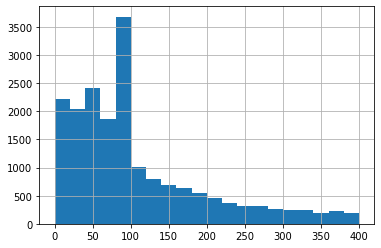

count    20884.000000
mean       161.792760
std        197.167412
min          1.000000
25%         45.000000
50%         95.000000
75%        191.000000
max       1580.000000
Name: days_exposition, dtype: float64

In [5]:
plot_hist(df, 'days_exposition', 'Срок продажи в днях', [0, 400])
df['days_exposition'].describe()

Среднее время продажи квартиры 161 день, чуть меньше полугода. 

Медиана 95 дней, значительно меньше среднего за счёт квартир, которые продаются очень долго.

Быстрыми можно считать продажи до 45 дней, а долгими - больше 191 дня.

Зависимость цены от этажа
floor_type
другой       4500000.0
первый       3800000.0
последний    4142900.0
Name: last_price, dtype: float64
floor_type
другой       4789765
первый       4043146
последний    4495819
Name: last_price, dtype: object


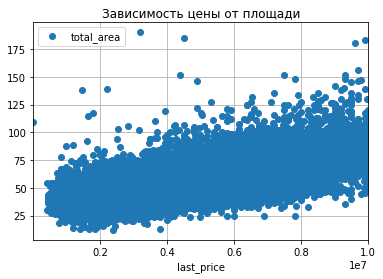

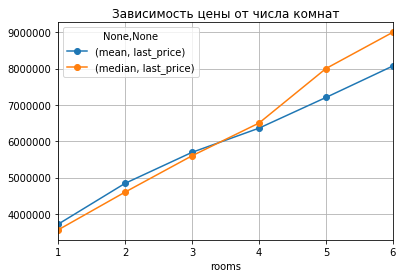

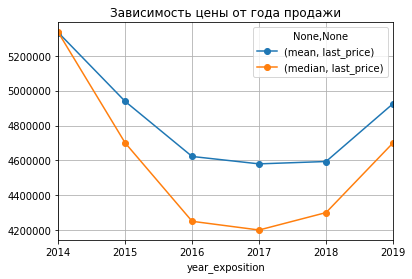

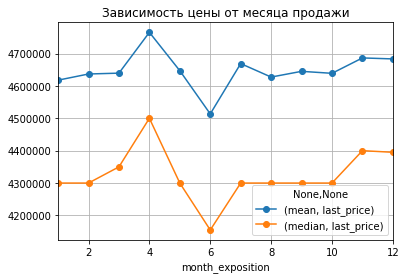

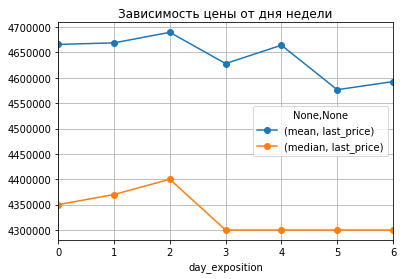

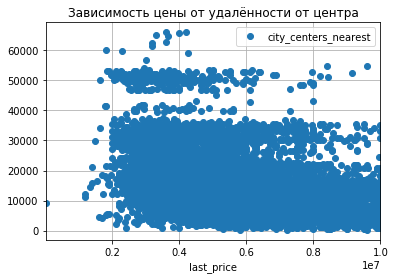

In [6]:
df.plot(title='Зависимость цены от площади', x='last_price', y='total_area',style='o', grid=True)

rooms_price = df.pivot_table(index='rooms', values='last_price', aggfunc=['mean', 'median'])
rooms_price.plot(title='Зависимость цены от числа комнат', style='o-', grid=True)

print('Зависимость цены от этажа')
print(df.groupby('floor_type')['last_price'].median())
print(df.groupby('floor_type')['last_price'].mean().map('{:.0f}'.format))

year_price = df.pivot_table(index='year_exposition', values='last_price', aggfunc=['mean', 'median'])
year_price.plot(title='Зависимость цены от года продажи', style='o-', grid=True)

month_price = df.pivot_table(index='month_exposition', values='last_price', aggfunc=['mean', 'median'])
month_price.plot(title='Зависимость цены от месяца продажи', style='o-', grid=True)

day_price = df.pivot_table(index='day_exposition', values='last_price', aggfunc=['mean', 'median'])
day_price.plot(title='Зависимость цены от дня недели', style='o-', grid=True)

df.plot(title='Зависимость цены от удалённости от центра', x='last_price', y='city_centers_nearest',style='o', grid=True)

- От площади квартиры цена зависит, но тут много вариантов, т.к. на цену влияет ещё много факторов
- Самые дешёвые квартиры на первом этаже, на порядок дороже последний, а самые дорогие средние этажи.
- От числа комнат стоимость зависит напрямую, чем больше комнат, тем больше цена
- В разные годы стоимость снижается и поднимается
- Летом меньше всего продаются квартиры, самый высокий спрос весной и около нового года
- Быстрее продаются квартиры, выставленные на продажу в начале недели
- От близости к центру разных населённых пунктов цена не особо зависит, думаю зависит от населённого пункта

       locality_name  count  price_area_mean
0    Санкт-Петербург  13087           104344
1     посёлок Мурино    522            85751
2     посёлок Шушары    437            78609
3         Всеволожск    393            66879
4            Колпино    335            75203
5             Пушкин    328            99966
6  посёлок Парголово    326            90331
7            Гатчина    305            68421
8    деревня Кудрово    297            92392
9             Выборг    234            58027


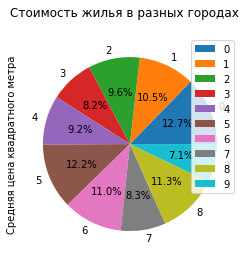

In [7]:
locality = df.pivot_table(index='locality_name', values='price_area', aggfunc=['count', 'mean'])
locality.columns = ['count', 'price_area_mean']
locality['price_area_mean'] = locality['price_area_mean'].astype('int')
locality.sort_values(by='count', ascending=False, inplace=True)
locality.reset_index(inplace=True)
locality = locality[: 10]
#locality.sort_values(by='price_area_mean', ascending=False, inplace=True)
#locality.plot(kind='pie',subplots=True,sharex=True,sharey=False,title='My title')
print(locality)
locality.plot(y='price_area_mean', kind='pie', subplots=True,sharex=True,sharey=False,
              title='Стоимость жилья в разных городах', autopct='%1.1f%%')
plt.ylabel('Средняя цена квадратного метра')
plt.show()

Самая высокая стоимость жилья в  Санкт-Петербурге, а самая низкая в Выборге - почти в два раза меньше.

Цена снижается равномерно в этих населённых пунктах.

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


                    last_price
centers_nearest_km            
0.0                  7775389.0
1.0                  7472054.0
2.0                  7214999.0
3.0                  6855165.0
4.0                  7130070.0
5.0                  6913046.0
6.0                  6393103.0
7.0                  6239375.0
8.0                  5837138.0
9.0                  5163231.0
10.0                 5127627.0
11.0                 5180084.0
12.0                 5141253.0
13.0                 5361402.0
14.0                 5168070.0
15.0                 5045166.0
16.0                 4932992.0
17.0                 4595252.0
18.0                 4703345.0
19.0                 4583555.0
20.0                 6174366.0
21.0                 4981709.0
22.0                 5055482.0
23.0                 4126867.0
24.0                 3862235.0
25.0                 4014913.0
26.0                 3575000.0
27.0                 2250000.0
28.0                 4910500.0
29.0                 3833333.0


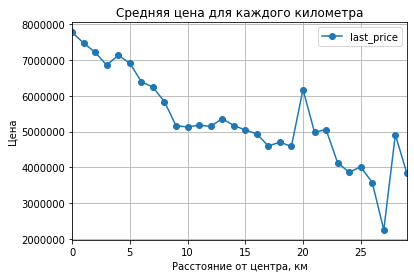

In [8]:
def nearest_km(value):
    if value != value:
        return value
    return int(value / 1000)


df_spb = df.query('locality_name == "Санкт-Петербург"')
df_spb.loc[:, 'centers_nearest_km'] = df_spb['city_centers_nearest'].apply(nearest_km)
km = df_spb.pivot_table(index='centers_nearest_km', values='last_price')
km['last_price'] = km['last_price'].map('{:.0f}'.format).astype('float')
print(km)
km.plot(title='Средняя цена для каждого километра', style='o-', grid=True)
plt.xlabel('Расстояние от центра, км')
plt.ylabel('Цена')
plt.show()

Центр я выделила в радиусе 8 километров, т.к. график резко меняется в этом месте.

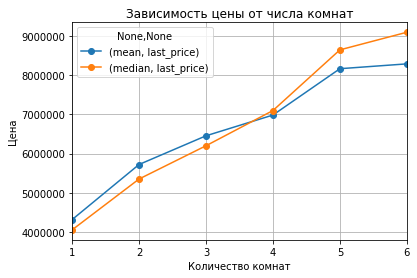

Зависимость цены от этажа
floor_type
другой       5100000.0
первый       4650000.0
последний    5150000.0
Name: last_price, dtype: float64
floor_type
другой       5454224
первый       4981558
последний    5544048
Name: last_price, dtype: object


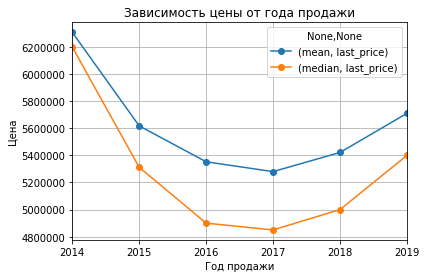

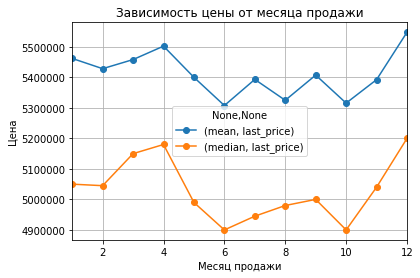

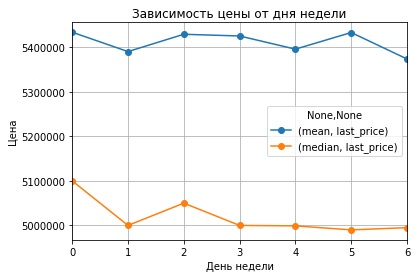

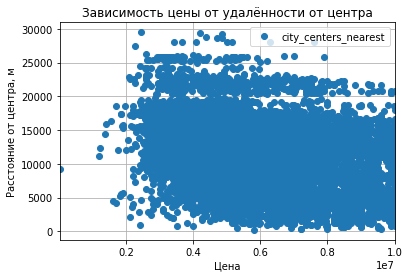

In [9]:
rooms_price_spb = df_spb.pivot_table(index='rooms', values='last_price', aggfunc=['mean', 'median']).plot(title='Зависимость цены от числа комнат', style='o-', grid=True)
rooms_price_spb.plot(title='Зависимость цены от числа комнат', style='o-', grid=True)
plt.xlabel('Количество комнат')
plt.ylabel('Цена')
plt.show()

print('Зависимость цены от этажа')
print(df_spb.groupby('floor_type')['last_price'].median())
print(df_spb.groupby('floor_type')['last_price'].mean().map('{:.0f}'.format))

year_price_spb = df_spb.pivot_table(index='year_exposition', values='last_price', aggfunc=['mean', 'median'])
year_price_spb.plot(title='Зависимость цены от года продажи', style='o-', grid=True)
plt.xlabel('Год продажи')
plt.ylabel('Цена')
plt.show()

month_price_spb = df_spb.pivot_table(index='month_exposition', values='last_price', aggfunc=['mean', 'median'])
month_price_spb.plot(title='Зависимость цены от месяца продажи', style='o-', grid=True)
plt.xlabel('Месяц продажи')
plt.ylabel('Цена')
plt.show()

day_price_spb = df_spb.pivot_table(index='day_exposition', values='last_price', aggfunc=['mean', 'median'])
day_price_spb.plot(title='Зависимость цены от дня недели', style='o-', grid=True)
plt.xlabel('День недели')
plt.ylabel('Цена')
plt.show()

df_spb.plot(title='Зависимость цены от удалённости от центра', x='last_price', y='city_centers_nearest',style='o', grid=True)
plt.xlabel('Цена')
plt.ylabel('Расстояние от центра, м')
plt.show()

Графики для всего города

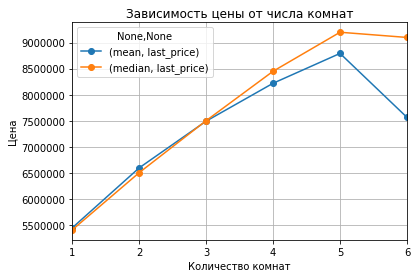

Зависимость цены от этажа
floor_type
другой       6800000.0
первый       5795000.0
последний    6900000.0
Name: last_price, dtype: float64
floor_type
другой       6778552
первый       5889653
последний    6861562
Name: last_price, dtype: object


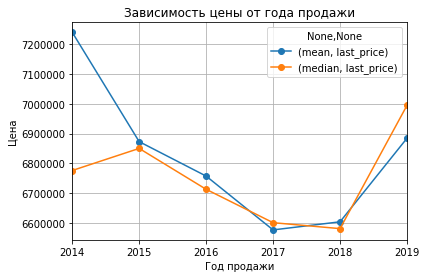

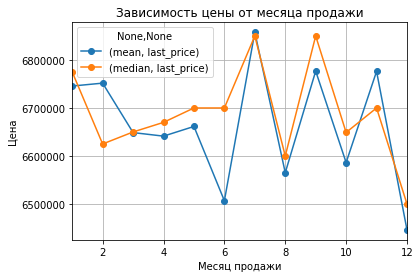

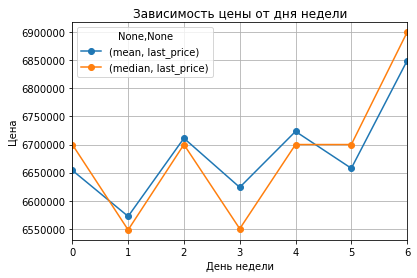

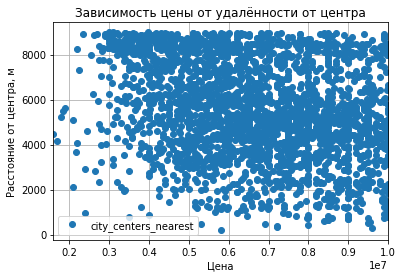

In [10]:
df_spb_center = df_spb.query('centers_nearest_km <= 8')

rooms_price_spb_center = df_spb_center.pivot_table(index='rooms', values='last_price', aggfunc=['mean', 'median'])
rooms_price_spb_center.plot(title='Зависимость цены от числа комнат', style='o-', grid=True)
plt.xlabel('Количество комнат')
plt.ylabel('Цена')
plt.show()

print('Зависимость цены от этажа')
print(df_spb_center.groupby('floor_type')['last_price'].median())
print(df_spb_center.groupby('floor_type')['last_price'].mean().map('{:.0f}'.format))

year_price_spb_center = df_spb_center.pivot_table(index='year_exposition', values='last_price', aggfunc=['mean', 'median'])
year_price_spb_center.plot(title='Зависимость цены от года продажи', style='o-', grid=True)
plt.xlabel('Год продажи')
plt.ylabel('Цена')
plt.show()

month_price_spb_center = df_spb_center.pivot_table(index='month_exposition', values='last_price', aggfunc=['mean', 'median'])
month_price_spb_center.plot(title='Зависимость цены от месяца продажи', style='o-', grid=True)
plt.xlabel('Месяц продажи')
plt.ylabel('Цена')
plt.show()


day_price_spb_center = df_spb_center.pivot_table(index='day_exposition', values='last_price', aggfunc=['mean', 'median'])
day_price_spb_center.plot(title='Зависимость цены от дня недели', style='o-', grid=True)
plt.xlabel('День недели')
plt.ylabel('Цена')
plt.show()


df_spb_center.plot(title='Зависимость цены от удалённости от центра', x='last_price', y='city_centers_nearest',style='o', grid=True)
plt.xlabel('Цена')
plt.ylabel('Расстояние от центра, м')
plt.show()

- Цены в центре выше, чем по городу в целом.
- По годам, месяцам и дням недели разницы нет
- Зависимость от числа комнат в центре больше коррелируется
- На краю центра более дорогие квартиры и их больше продаётся
- Потолки в центре немного выше чем в среднем по городу, примерно на 10 см и площадь у них побольше метров на 5-10. При этом количество комнат примерно одинаковое

### Шаг 5. Общий вывод

Стоимость квартиры зависит от площади, высоты потолком, расстояния от центра.

Самые дорогие квартиры в Санкт-Петербурге. В своей выборке я анализировала в основном квартиры средней цены, не слишком большой площади. Частные дома(судя по площади и количеству комнат) я старалась отбросить.

Также есть зависимость от сезонов года и даже дня недели, когда выставили квартиру на продажу.